In [37]:
import random
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import dateutil
from sklearn.linear_model import LinearRegression

### Notes on Mixed effects linear models

1. Mixed means a combination of both fixed effects and random effects
2. Fixed and Random effects has little to do with the variables themselves. It arises more from how you pose your research question and experimental design. 
    1. Fixed effect is any variable X that will affect the response variable Y. 
    2. Random effect is better termed "grouping factor"
        1. They are always categorical
        2. Not so interested in how they impact the response variable
        3. More interested in how they influence the patterns we observe
        4. The instances of our random effect are just a sample of all possible. We only sampled 10 Nile rats out of all rats in the lab. 
        5. We want to know how much variance is attributable to the random effect when we predict intensity
            6. We want to control for the effects of selecting those 10 Nile rats randomly, and we want to extend our result to Nile rats in general. 
        6. If we cared about each of the 10 mice specifically (because they were special in some way), then we would model the 10 mice as a fixed effect. 
    3. General rule: random effect should have at least 5 levels.
        1. Any less and you should model it as a fixed effect, e.g. sex (M/F), random-fed/fasted
    4. This is because you want to calculate a variance from your random effect, and any less than 5 data points will lead to questionable variance results.
3. The mixed model answers the question: "Does the correlation between feature intensity and F/R + OGTT exist after controlling for the variation in rats?


## What is the difference between multicolinearity and dependence? 

### Multicolinearity is a type of dependence.

### 1. Multicolinearity occurs when features are non-independent .
####             (e.g. one feature is [M+H]+ and another feature is the corresponding [M+Na]+ adduct

## 2. You can also have dependence when statistical observations are grouped (e.g. multiple observations over several weeks from the same animal, like here!)

See the intro of this article https://towardsdatascience.com/how-linear-mixed-model-works-350950a82911

In [30]:
fr_raw = pd.read_csv(r'..\data\search\peak_finder\Final_Results.csv').dropna(axis=1, how='all')
fr_norm = pd.read_csv(r'..\data\processed\lipidomics_linregress_normalized_data.csv')
fr_filt = pd.read_csv(r'..\data\processed\lipidomics_normalized_filtered_data.csv', index_col=0)
file_grouping = pd.read_csv(r'..\data\metadata\file_grouping.csv', index_col=0)

fr_quant_filenames_in_analytical_order = file_grouping[file_grouping['quant_file'] == True]['fr_name'].to_list()

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]
bg_dict = {'diabetic': diabetic, 'impaired': impaired, 'normal': normal}
animal_to_tolerance_dict = {1076: 'diabetic', 1082: 'diabetic',1101: 'diabetic',
                            1060: 'impaired', 1062: 'impaired', 1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 
                            1091: 'normal', 1093: 'normal',}

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', 
                                  sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')
# animal_phenotypes.set_index('animal', inplace=True)

In [31]:
animal_phenotypes['animal']

0     1060
1     1061
2     1062
3     1063
4     1074
5     1075
6     1076
7     1080
8     1081
9     1082
10    1091
11    1092
12    1093
13    1094
14    1095
15    1096
16    1100
17    1101
18    1102
Name: animal, dtype: int32

In [32]:
file_grouping

,analytical_run_order,fr_name,rat_label,bg_type,quant_file,week,lipidex_file_number,date,glucose_tolerance,bg
File Name,,,,,,,,,,
20210729_AJ_Toh_RatBloodGlucose_Water_R1,1,20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (...,NaN,NaN,False,NaN,65,NaN,NaN,NaN
20210729_AJ_Toh_RatBloodGlucose_Water_R2,2,20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (...,NaN,NaN,False,NaN,66,NaN,NaN,NaN
20210729_AJ_Toh_RatBloodGlucose_Water_R3,3,20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (...,NaN,NaN,False,NaN,67,NaN,NaN,NaN
20210729_AJ_Toh_RatBloodGlucose_SolventBlank,4,20210729_AJ_Toh_RatBloodGlucose_SolventBlank.r...,NaN,NaN,False,NaN,2,NaN,NaN,NaN
20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank,5,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlan...,NaN,NaN,False,NaN,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
20210729_AJ_Toh_RatBloodGlucose_T1062M_20210401_9wk_RBG,63,20210729_AJ_Toh_RatBloodGlucose_T1062M_2021040...,1062.0,RBG,True,9.0,14,2021-04-01,impaired,250.5
20210729_AJ_Toh_RatBloodGlucose_T1101M_20210330_8wk_RBG,64,20210729_AJ_Toh_RatBloodGlucose_T1101M_2021033...,1101.0,RBG,True,8.0,54,2021-03-30,diabetic,459.5
20210729_AJ_Toh_RatBloodGlucose_T1092M_20210330_8wk_RBG,65,20210729_AJ_Toh_RatBloodGlucose_T1092M_2021033...,1092.0,RBG,True,8.0,42,2021-03-30,impaired,76.0


In [33]:
df = fr_filt
df = np.log2(df[fr_quant_filenames_in_analytical_order].T)
fg = file_grouping[file_grouping['fr_name'].isin(fr_quant_filenames_in_analytical_order)]
fg = fg.reset_index()[['fr_name', 'rat_label', 'bg_type', 'glucose_tolerance', 'bg']].set_index('fr_name')
df = df.join(fg)
ogtt_lookup = animal_phenotypes[['animal', 'OGTT (AUC)']]
df['ogtt'] = df['rat_label'].apply(lambda x: ogtt_lookup[ogtt_lookup['animal'] == (int(x))]['OGTT (AUC)'].values[0])
# rename columns to remove '.' because it messes with the formula notation 
new_cols = {}
for col in df.columns:
    new_cols[col] = col.replace('.', '').replace(':', '').replace('-', '')\
    .replace('[', '').replace(']', '')
df = df.rename(new_cols, axis=1)
display(df)

,unknown_67905463_0536,unknown_6411087_0537,unknown_95115973_0541,unknown_32903067_0542,unknown_96913147_0544,unknown_62313641_0546,unknown_29108359_0551,unknown_35299652_0553,unknown_24709372_0554,unknown_60514441_0555,...,unknown_89782532_20148,unknown_9749118_20163,unknown_59358716_20175,unknown_87180945_20196,unknown_100393829_20435,rat_label,bg_type,glucose_tolerance,bg,ogtt
20210729_AJ_Toh_RatBloodGlucose_T1076M_20210405_10wk_FBG.raw (F27),20.405355,21.533648,20.665848,24.400930,19.378685,23.049698,28.481360,19.316892,24.328078,19.478253,...,18.897008,16.810111,17.724121,18.400646,16.655211,1076.0,FBG,diabetic,71.000000,2321.25
20210729_AJ_Toh_RatBloodGlucose_T1062M_20210322_8wk_FBG.raw (F9),23.313111,24.586227,23.731244,26.811664,22.709669,26.254519,30.305095,22.008084,26.237893,23.669177,...,19.348489,17.364343,19.240306,18.585339,16.313637,1062.0,FBG,impaired,52.333333,1648.75
20210729_AJ_Toh_RatBloodGlucose_T1093M_20210402_9wk_FBG.raw (F49),23.218699,24.375151,23.038733,26.708762,21.722467,26.085255,29.595696,22.149967,25.628550,23.638288,...,21.529536,20.099612,21.430516,20.968101,19.339229,1093.0,FBG,normal,64.000000,993.00
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4),24.012349,25.685664,24.916555,25.977120,23.985839,27.293718,31.938325,22.246767,27.005584,24.827176,...,17.921098,18.430542,17.488155,16.202162,17.985491,1060.0,RBG,impaired,225.000000,1761.75
20210729_AJ_Toh_RatBloodGlucose_T1091M_20210410_10wk_FBG.raw (F39),24.302356,25.422294,24.042666,27.313654,22.321161,26.913271,30.455412,22.475813,26.363764,23.854459,...,20.133479,17.986741,19.996615,19.778245,17.357845,1091.0,FBG,normal,48.500000,846.75
20210729_AJ_Toh_RatBloodGlucose_T1092M_20210406_9wk_RBG.raw (F44),23.901455,24.936916,24.162971,27.337061,23.184906,26.682437,30.690269,22.495336,26.325506,23.984926,...,17.824376,18.099621,17.383197,15.556400,17.582655,1092.0,RBG,impaired,70.500000,1377.95
20210729_AJ_Toh_RatBloodGlucose_T1093M_20210413_10wk_RBG.raw (F52),23.883301,24.779941,23.627979,27.415597,22.795191,26.236176,29.854529,22.337295,25.798043,23.349277,...,18.836779,18.145468,18.282680,16.603878,17.887551,1093.0,RBG,normal,69.500000,993.00
20210729_AJ_Toh_RatBloodGlucose_T1082M_20210405_10wk_FBG.raw (F33),23.387975,24.696276,24.085858,27.230430,22.878785,26.307266,30.106764,22.612902,26.021376,23.659766,...,19.255315,14.496938,19.507853,19.379093,13.846921,1082.0,FBG,diabetic,50.000000,2224.75
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210401_9wk_RBG.raw (F6),24.421692,25.054941,23.169508,27.598719,22.397716,26.123572,29.717328,22.790052,25.559916,22.258087,...,18.261890,18.854601,17.718258,16.494586,18.466842,1060.0,RBG,impaired,83.000000,1761.75
20210729_AJ_Toh_RatBloodGlucose_T1101M_20210402_9wk_FBG.raw (F55),23.463756,24.934805,24.010849,27.126653,22.703282,26.680311,30.314104,22.526302,26.226352,24.184003,...,19.685160,18.324624,19.526233,18.844052,17.739443,1101.0,FBG,diabetic,43.000000,2015.75


In [56]:
smf.ols(f"{random_col} ~ ogtt + bg_type", df).fit(maxiter=100).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     TG_180_205_204_94679138_15972   R-squared:                       0.504
Model:                                       OLS   Adj. R-squared:                  0.486
Method:                            Least Squares   F-statistic:                     28.95
Date:                           Thu, 30 Dec 2021   Prob (F-statistic):           2.11e-09
Time:                                   11:38:41   Log-Likelihood:                -75.486
No. Observations:                             60   AIC:                             157.0
Df Residuals:                                 57   BIC:                             163.3
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         20.6749      0.425     48.639      0.000      19.824      21.526
bg_type[T.RBG]    -0.8228      0.226     -3.648      0.001      -1.274      -0.371
ogtt               0.0016      0.000      6.677      0.000       0.001       0.002
==============================================================================
Omnibus:                        0.897   Durbin-Watson:                   1.723
Prob(Omnibus):                  0.639   Jarque-Bera (JB):                0.715
Skew:                          -0.265   Prob(JB):                        0.699
Kurtosis:                       2.929   Cond. No.                     6.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [66]:
smf.ols(f"{random_col} ~ ogtt * bg_type", df).fit(maxiter=100).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     TG_180_205_204_94679138_15972   R-squared:                       0.589
Model:                                       OLS   Adj. R-squared:                  0.567
Method:                            Least Squares   F-statistic:                     26.73
Date:                           Thu, 30 Dec 2021   Prob (F-statistic):           7.33e-11
Time:                                   12:05:13   Log-Likelihood:                -69.853
No. Observations:                             60   AIC:                             147.7
Df Residuals:                                 56   BIC:                             156.1
Df Model:                                      3                                         
Covariance Type:                       nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              21.9057      0.532     41.149      0.000      20.839      22.972
bg_type[T.RBG]         -3.2844      0.753     -4.363      0.000      -4.793      -1.776
ogtt                    0.0009      0.000      2.736      0.008       0.000       0.001
ogtt:bg_type[T.RBG]     0.0015      0.000      3.401      0.001       0.001       0.002
==============================================================================
Omnibus:                        0.987   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.610   Jarque-Bera (JB):                0.902
Skew:                          -0.053   Prob(JB):                        0.637
Kurtosis:                       2.409   Cond. No.                     1.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
# "Y ~ A + B + A:B" is the same formula as "Y ~ A * B"

c = smf.ols(f"{random_col} ~ ogtt + bg_type + ogtt:bg_type", df).fit(maxiter=100)
c.summary()
# c.model.formula

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     TG_180_205_204_94679138_15972   R-squared:                       0.589
Model:                                       OLS   Adj. R-squared:                  0.567
Method:                            Least Squares   F-statistic:                     26.73
Date:                           Thu, 30 Dec 2021   Prob (F-statistic):           7.33e-11
Time:                                   11:41:39   Log-Likelihood:                -69.853
No. Observations:                             60   AIC:                             147.7
Df Residuals:                                 56   BIC:                             156.1
Df Model:                                      3                                         
Covariance Type:                       nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              21.9057      0.532     41.149      0.000      20.839      22.972
bg_type[T.RBG]         -3.2844      0.753     -4.363      0.000      -4.793      -1.776
ogtt                    0.0009      0.000      2.736      0.008       0.000       0.001
ogtt:bg_type[T.RBG]     0.0015      0.000      3.401      0.001       0.001       0.002
==============================================================================
Omnibus:                        0.987   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.610   Jarque-Bera (JB):                0.902
Skew:                          -0.053   Prob(JB):                        0.637
Kurtosis:                       2.409   Cond. No.                     1.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [76]:
t = smf.mixedlm(f"{random_col} ~ ogtt * bg_type", df, groups=df['rat_label'])

In [77]:
t.fit()

### Because every animal has one unique OGTT value (continuous value), that OGTT value and the animal number are counfounders. 

### Therefore a model of `Intensity ~ OGTT  x  bg_type + (1|Animal)` is not valid.

### In this case, use only fixed effects (i.e. a regular linear model) with `Intensity ~ OGTT x bg_type`

In [122]:
random_col = random.choice(df.drop(df.filter(regex='unknown').columns, axis=1).columns)

##### not statistically sound:
# lmem_continuous = smf.mixedlm(f"{random_col} ~ ogtt * bg_type", df, groups=df['rat_label']).fit(maxiter=100) 

lm_continuous = smf.ols(f"{random_col} ~ ogtt * bg_type", df).fit(maxiter=100)
lmem_categorical = smf.mixedlm(f"{random_col} ~ glucose_tolerance * bg_type", 
                               df, groups=df['rat_label']).fit(maxiter=100)



print(random_col, '\n')
# print(lmem_continuous.summary(), "\n\n")
print(lm_continuous.summary(), '\n\n')
print(lmem_categorical.summary())

SM_d407_77557587_7648 

                              OLS Regression Results                             
Dep. Variable:     SM_d407_77557587_7648   R-squared:                       0.692
Model:                               OLS   Adj. R-squared:                  0.676
Method:                    Least Squares   F-statistic:                     42.02
Date:                   Thu, 30 Dec 2021   Prob (F-statistic):           2.34e-14
Time:                           14:42:41   Log-Likelihood:                -19.837
No. Observations:                     60   AIC:                             47.67
Df Residuals:                         56   BIC:                             56.05
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [140]:
lmem_categorical.params

Intercept                                       20.801829
glucose_tolerance[T.impaired]                   -0.231655
glucose_tolerance[T.normal]                     -0.692410
bg_type[T.RBG]                                  -0.513503
glucose_tolerance[T.impaired]:bg_type[T.RBG]    -0.432804
glucose_tolerance[T.normal]:bg_type[T.RBG]      -0.253706
Group Var                                        0.363817
dtype: float64

In [155]:
lmem_categorical.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
========================================================================================
Model:                   MixedLM        Dependent Variable:        SM_d407_77557587_7648
No. Observations:        60             Method:                    REML                 
No. Groups:              10             Scale:                     0.1069               
Min. group size:         6              Log-Likelihood:            -27.0000             
Max. group size:         6              Converged:                 Yes                  
Mean group size:         6.0                                                            
----------------------------------------------------------------------------------------
                                             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                    20.802    0.158 131.990 0.000 20.493 21.111
glucose_tolerance[T.impaired]                -0.232    0.199  -1.162 0.245 -0.622  0.159
glucose_tolerance[T.normal]                  -0.692    0.249  -2.779 0.005 -1.181 -0.204
bg_type[T.RBG]                               -0.514    0.154  -3.332 0.001 -0.816 -0.211
glucose_tolerance[T.impaired]:bg_type[T.RBG] -0.433    0.195  -2.220 0.026 -0.815 -0.051
glucose_tolerance[T.normal]:bg_type[T.RBG]   -0.254    0.244  -1.041 0.298 -0.731  0.224
Group Var                                     0.039    0.099                            
========================================================================================

"""

In [154]:
lmem_categorical.params

Intercept                                       20.801829
glucose_tolerance[T.impaired]                   -0.231655
glucose_tolerance[T.normal]                     -0.692410
bg_type[T.RBG]                                  -0.513503
glucose_tolerance[T.impaired]:bg_type[T.RBG]    -0.432804
glucose_tolerance[T.normal]:bg_type[T.RBG]      -0.253706
Group Var                                        0.363817
dtype: float64

In [123]:
lmem_categorical.model.formula

'SM_d407_77557587_7648 ~ glucose_tolerance * bg_type'

In [ ]:
# Overall formula
# Intensity ~ (Beta1*glucose_tolerance) + (Beta2*feeding_bg_type) + (Beta3 * gluc_tol * bg_type)

SM_d407_77557587_7648
Intercept                                       20.801829
glucose_tolerance[T.impaired]                   -0.231655
glucose_tolerance[T.normal]                     -0.692410
bg_type[T.RBG]                                  -0.513503
glucose_tolerance[T.impaired]:bg_type[T.RBG]    -0.432804
glucose_tolerance[T.normal]:bg_type[T.RBG]      -0.253706
Group Var                                        0.363817
dtype: float64


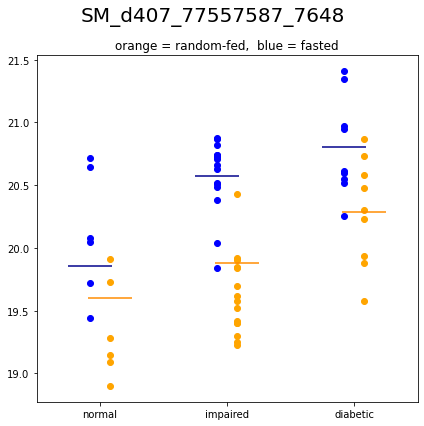

In [189]:
# Using categorical Diabetes type (normal vs. impaired vs. diabetic)

print(random_col)
fig = plt.gcf()
fig.set_size_inches(6, 6)
fig.suptitle(random_col, fontsize=20)
ax = plt.subplot(111)
ax.set_xlim((-0.5, 2.5))
ax.set_title('orange = random-fed,  blue = fasted', fontsize=12)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['normal', 'impaired', 'diabetic'])
offset = 0.08

for i, animal in enumerate(animals_used):    
    gluc_tol_type = animal_to_tolerance_dict[animal]
    if gluc_tol_type == 'normal':
        gluc_tol_type_position = 0
    elif gluc_tol_type == 'impaired':
        gluc_tol_type_position = 1
    elif gluc_tol_type == 'diabetic':
        gluc_tol_type_position = 2

#     ax.set_title(str(animal) + ' ' + str(animal_to_tolerance_dict[animal]) + '\n' + str(ogtt_value) + ' OGTT')
#     ax.set_xticks([1,2])
#     ax.set_xticklabels( ['Random', 'Fasted'])
    
    for j, bg_type in enumerate(['RBG', 'FBG']):
        data = df[(df['rat_label'] == animal) & (df['bg_type'] == bg_type)][random_col]
        color = ('orange' if j == 0 else 'blue')
        offset_ = (offset if bg_type == 'RBG' else -offset)
        ax.scatter(x=len(data)*[gluc_tol_type_position + offset_] , 
                   y=data,
                   color=color)
        
params = lmem_categorical.params

# FBG is the main value. RBG uses the 'bg_type[T.RBG]' correction
# Diabetic is the main value, then there are corrections for glucose_tolerance[T.impaired], glucose_tolerance[T.normal]
diabetic_fbg = params['Intercept']
diabetic_rbg = diabetic_fbg + params['bg_type[T.RBG]']

impaired_fbg = diabetic_fbg + params['glucose_tolerance[T.impaired]']
normal_fbg = diabetic_rbg + params['glucose_tolerance[T.impaired]:bg_type[T.RBG]']

impaired_rbg = impaired_fbg + params['glucose_tolerance[T.normal]']
normal_rbg = normal_fbg + params['glucose_tolerance[T.normal]:bg_type[T.RBG]']

plt.scatter([2 - offset], [diabetic_fbg], color='darkblue', s=2000, marker='_')  # Diabetic FBG
plt.scatter([2 + offset], [diabetic_rbg], color='darkorange', s=2000, marker='_') # Diabetic RBG
plt.scatter([1 - offset], [impaired_fbg], color='darkblue', s=2000, marker='_')
plt.scatter([1 + offset], [impaired_rbg], color='darkorange', s=2000, marker='_')
plt.scatter([0 - offset], [normal_fbg], color='darkblue', s=2000, marker='_')
plt.scatter([0 + offset], [normal_rbg], color='darkorange', s=2000, marker='_')

plt.tight_layout()
print(params)

PlasmanylPC_O344_74056061_8327
Intercept              21.429883
bg_type[T.RBG]         -4.275858
ogtt                    0.001156
ogtt:bg_type[T.RBG]     0.001550
Group Var               0.491407
dtype: float64


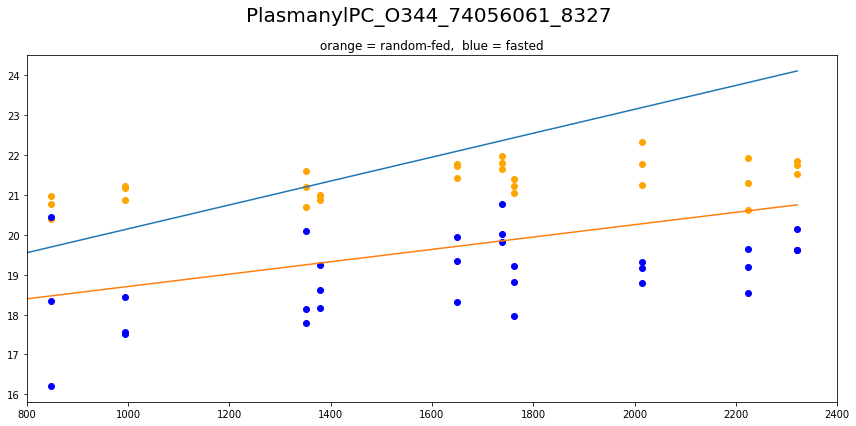

In [119]:
print(random_col)
for i, animal in enumerate(animals_used):
    ax = plt.subplot(111)
    ax.set_xlim((800, 2400))
    ogtt_value = animal_phenotypes.loc[animal_phenotypes['animal'] == animal, 'OGTT (AUC)']
    ax.set_title('orange = random-fed,  blue = fasted', fontsize=12)
#     ax.set_title(str(animal) + ' ' + str(animal_to_tolerance_dict[animal]) + '\n' + str(ogtt_value) + ' OGTT')
#     ax.set_xticks([1,2])
#     ax.set_xticklabels( ['Random', 'Fasted'])
    data = df[[random_col, 'rat_label', 'bg_type', 'ogtt']]
    
    for j, bg_type in enumerate(['RBG', 'FBG']):
        color = 'orange' if j == 0 else 'blue'
        ax.scatter(3*[ogtt_value], df[random_col].filter(regex=(str(animal))).filter(regex=bg_type), color=color)

intercept = lmem_continuous.params['Intercept']
bg_typeTRBG = lmem_continuous.params['bg_type[T.RBG]']
ogtt = lmem_continuous.params['ogtt']
ogttbgtype = lmem_continuous.params['ogtt:bg_type[T.RBG]']
re = lmem_continuous.random_effects

plt.plot([0, 2321.25], [(intercept + bg_typeTRBG), intercept + 2321.25 * ogtt])  
plt.plot([0, 2321.25], [(intercept + bg_typeTRBG), (intercept + bg_typeTRBG) + 2321.25 * (ogttbgtype)])

        
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.suptitle(random_col, fontsize=20)
plt.tight_layout()
print(lmem_continuous.params)

TG_532_89081793_1815


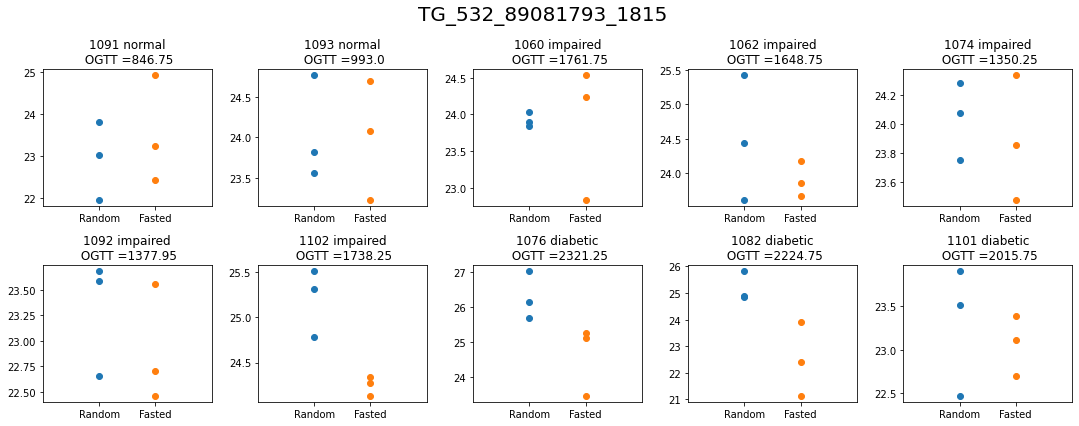

In [112]:
print(random_col)
for i, animal in enumerate(animals_used):
    ax = plt.subplot(2, 5, i+1)
    ax.set_xlim((0, 3))
    ogtt_value = animal_phenotypes.loc[animal_phenotypes['animal'] == animal, 'OGTT (AUC)'].values[0]
    ax.set_title(str(animal) + ' ' + str(animal_to_tolerance_dict[animal]) + '\n' + ' OGTT =' + str(ogtt_value))
    ax.set_xticks([1,2])
    ax.set_xticklabels( ['Random', 'Fasted'])
    for j, bg_type in enumerate(['RBG', 'FBG']):
        
        
        
        ax.scatter(3*[j+1], df[random_col].filter(regex=(str(animal))).filter(regex=bg_type))
        
        
# plt.xticks(range(1,11), [str(animal) for animal in animals_used]);
fig = plt.gcf()
fig.set_size_inches(15, 6)
fig.suptitle(random_col, fontsize=20)
plt.tight_layout()